<a href="https://colab.research.google.com/github/analystanand/Machine-Learning/blob/master/Decision_Tree_ID3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree

Implementation of ID3

### Dataset https://archive.ics.uci.edu/ml/datasets/MONK's+Problems

1. Download the data and place it in current directory

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [0]:
def partition(x):
    """
    Partition the column vector x into subsets indexed by its unique values (v1, ... vk)
    Returns a dictionary of the form
    { v1: indices of x == v1,
      v2: indices of x == v2,
      ...
      vk: indices of x == vk }, where [v1, ... vk] are all the unique values in the vector z.
    """
    res = {i: [] for i in set(x)}
    for index, i in enumerate(x):
        res[i].append(index)
    return res

In [0]:
def entropy(y):
    """
    Compute the entropy of a vector y by considering the counts of the unique values (v1, ... vk), in z

    Returns the entropy of z: H(z) = p(z=v1) log2(p(z=v1)) + ... + p(z=vk) log2(p(z=vk))
    """
    rep_dict = partition(y)
    H_z = 0
    for k, v in rep_dict.items():
        p = len(v) / len(y)
        H_z += -p * np.log2(p)
    return H_z


In [0]:
def mutual_information(x, y):
    """
    Compute the mutual information between a data column (x) and the labels (y). The data column is a single attribute
    over all the examples (n x 1). Mutual information is the difference between the entropy BEFORE the split set, and
    the weighted-average entropy of EACH possible split.

    Returns the mutual information: I(x, y) = H(y) - H(y | x)
    """
    H_y = entropy(y)
    feature_partition = partition(x)
    H_y_x = 0
    for k, v in feature_partition.items():
        weightage = len(v) / len(y)
        H_y_x += weightage * entropy([y[k] for k in v])
    I = H_y - H_y_x
    return I


In [0]:
def get_majority(y):
    res = partition(y)
    max = 0
    majority = 0
    for k, v in res.items():
        if len(v) > max:
            max = len(v)
            majority = k
    return majority


In [0]:
def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5):
    """
    Implements the classical ID3 algorithm given training data (x), training labels (y) and an array of
    attribute-value pairs to consider.
   """
    tree = {}
    # entire set of label is pure
    e = partition(y)
    if len(e) == 1:
        return y[0]
    # attribute set is empty
    elif not attribute_value_pairs or depth == max_depth:
        return get_majority(y)
    else:
        # check best information gain among list of features
        ml_info_gain = -1.0
        best_feature, best_value = 0, 0
        pos_subset_indx, neg_subset_indx = [], []
        for i in attribute_value_pairs:
            feature, value = i[0], i[1]
            temp_x = [1 if k == value else 0 for k in x[:, feature]]
            m = mutual_information(temp_x, y)
            if m > ml_info_gain:
                ml_info_gain = m
                best_feature, best_value = feature, value
                pos_subset_indx = np.where(x[:, feature] == value)[0]
                neg_subset_indx = np.where(x[:, feature] != value)[0]

        modified_x_pos = np.take(x, pos_subset_indx, axis=0)
        modified_y_pos = np.take(y, pos_subset_indx)

        modified_x_neg = np.take(x, neg_subset_indx, axis=0)
        modified_y_neg = np.take(y, neg_subset_indx)

        temp_attr_value = (best_feature, best_value)

        av1, av2 = attribute_value_pairs.copy(), attribute_value_pairs.copy()
        av1.remove(temp_attr_value)
        av2.remove(temp_attr_value)
        tree[(best_feature, best_value, True)] = id3(modified_x_pos,
                                                     modified_y_pos,
                                                     av1,
                                                     depth + 1, max_depth)
        tree[(best_feature, best_value, False)] = id3(modified_x_neg,
                                                      modified_y_neg,
                                                      av2,
                                                      depth + 1, max_depth)
        return tree



In [0]:
def predict_example(x, tree):
    """
    Predicts the classification label for a single example x using tree by recursively descending the tree until
    a label/leaf node is reached.

    Returns the predicted label of x according to tree
    """
    if tree == 0 or tree == 1 or tree==2:
        return tree
    attr_pair = list(tree.keys())[0]
    key, val = attr_pair[0], attr_pair[1]
    res = bool(x[key] == val)
    return predict_example(x, tree[key, val, res])


In [0]:
def compute_error(y_true, y_pred):
    """
    Computes the average error between the true labels (y_true) and the predicted labels (y_pred)

    Returns the error = (1/n) * sum(y_true != y_pred)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    error = np.sum(y_true != y_pred)
    error = (1 / len(y_true)) * error
    return error


In [0]:
def visualize(tree, depth=0):
    """
    Pretty prints (kinda ugly, but hey, it's better than nothing) the decision tree to the console. Use print(tree) to
    print the raw nested dictionary representation.
    DO NOT MODIFY THIS FUNCTION!
    """
    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1}]'.format(split_criterion[0], split_criterion[1]))

        # Print the children
        if type(sub_trees) is dict:
            visualize(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))



In [0]:
def plot_graph(trn, tst, dataset):
    plt.figure(figsize=(12,8))
    x = [i for i in range(1, len(trn) + 1)]
    plt.plot(x, trn, "r", label="Train")
    plt.plot(x, tst, "b", label="Test")
    plt.ylabel("Error Rate")
    plt.xlabel("Depth of Tree")
    plt.legend()
    # plt.savefig(dataset + '.png')
    plt.show()


In [0]:
def confuse(y, y_hat,dataset,depth):
    cm = confusion_matrix(y,y_hat)
    plt.clf()
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative', 'Positive']
    plt.title(dataset+'Depth-'+str(depth))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(s[i][j]) + " = " + str(cm[i][j]))
    plt.show()

In [0]:
def depth_vs_error_rate(Xtrn,ytrn,Xtst,max_depth):
    for k in range(1, max_depth):
        attr_value = []
        for i in range(Xtrn.shape[1]):
            attr_value.extend([(i, k) for k in set(Xtrn[:, i])])
        decision_tree = id3(Xtrn, ytrn, attribute_value_pairs=attr_value, max_depth=k)


        # visualize(decision_tree)
        # Compute the train error
        y_pred_trn = [predict_example(x, decision_tree) for x in Xtrn]
        trn_err = compute_error(ytrn, y_pred_trn)
        trn_err_list.append(trn_err)

        # Compute the test error
        y_pred_tst = [predict_example(x, decision_tree) for x in Xtst]

        

        tst_err = compute_error(ytst, y_pred_tst)
        tst_err_list.append(tst_err)

    plot_graph(trn_err_list, tst_err_list, dataset)

<Figure size 432x288 with 0 Axes>

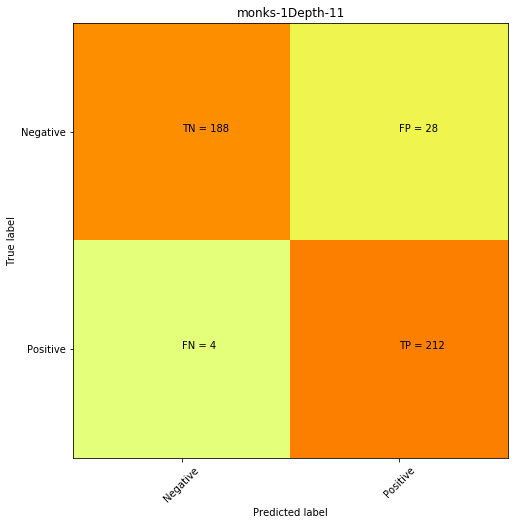

In [189]:
  dataset = "monks-1"
  train_file = 'monks-1.train'  
  test_file = 'monks-1.test'
  depth = 11

  # Load the train data
  M = np.genfromtxt(train_file, missing_values=0, skip_header=0, delimiter=',', dtype=int)
  ytrn = M[:, 0]
  Xtrn = M[:, 1:]

  # Load the test data
  M = np.genfromtxt(test_file, missing_values=0, skip_header=0, delimiter=',', dtype=int)
  ytst = M[:, 0]
  Xtst = M[:, 1:]
  trn_err_list, tst_err_list = [], []
  decision_tree = id3(Xtrn, ytrn, attribute_value_pairs=attr_value, max_depth=max_depth)
  confuse(ytst, y_pred_tst,dataset,depth)
  

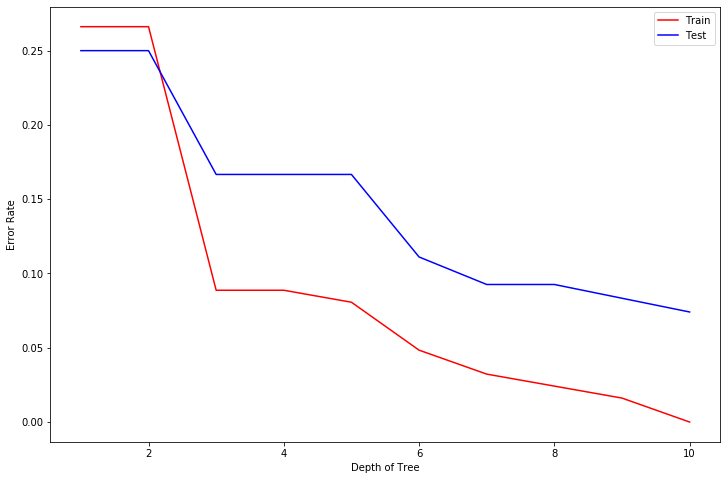

In [190]:
depth_vs_error_rate(Xtrn,ytrn,Xtst,max_depth)